In [1]:

# basic packages
import pandas as pd
import numpy as np
import datetime as dt
from pytz import timezone
import urllib
import os
import math
from scipy import stats
from scipy.signal import find_peaks, spectrogram

# packages for visualizations
import matplotlib.dates as mdates
import seaborn as sns

from prophet import Prophet
from prophet.plot import plot_seasonality , plot_weekly, plot_yearly

from matplotlib import pyplot as plt


/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = './CC_LCL-FullData_without_stdorToU.csv.gz'

df=pd.read_csv(file_path ,  nrows=100000000)
df


# Assuming your DataFrame is named 'df'
# Convert 'DateTime' column to datetime type if it's not already
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Filter rows based on the condition
df = df[df['DateTime'] >= '2012-12-03']

df

,LCLid,DateTime,KWH/hh (per half hour)
2447,MAC000002,2012-12-03 00:00:00,0.255
2448,MAC000002,2012-12-03 00:30:00,0.207
2449,MAC000002,2012-12-03 01:00:00,0.231
2450,MAC000002,2012-12-03 01:30:00,0.224
2451,MAC000002,2012-12-03 02:00:00,0.178
...,...,...,...
99999995,MAC004268,2013-06-29 07:00:00,0.151
99999996,MAC004268,2013-06-29 07:30:00,0.278
99999997,MAC004268,2013-06-29 08:00:00,0.128
99999998,MAC004268,2013-06-29 08:30:00,0.049


In [3]:
df['KWH/hh (per half hour) '] = pd.to_numeric(df['KWH/hh (per half hour) '], errors='coerce')

df['KWH/hh (per half hour) '] = df['KWH/hh (per half hour) '].fillna(df['KWH/hh (per half hour) '].mean())

In [4]:
import pandas as pd

# Assuming df is your DataFrame
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Find the minimum date for each LCLid
min_dates = df.groupby('LCLid')['DateTime'].min()

# Create a new DataFrame with a DateTime column containing unique date times
unique_datetimes = pd.DataFrame(df['DateTime'].unique(), columns=['DateTime'])

# Initialize an empty DataFrame to store the final result
average_df = unique_datetimes.copy()

# Iterate through LCLids and merge data
for lclid, min_date in min_dates.items():
    lclid_data = df[df['LCLid'] == lclid].copy()
    lclid_data['TimeDelta'] = (lclid_data['DateTime'] - min_date).dt.total_seconds() / 3600
    lclid_data = lclid_data.drop_duplicates(subset=['DateTime'])  # Drop duplicates
    lclid_data_pivot = lclid_data.pivot(index='DateTime', columns='LCLid', values='KWH/hh (per half hour) ')
    average_df = pd.merge(average_df, lclid_data_pivot, how='left', left_on='DateTime', right_on='DateTime')

# If you want to reset the index and fill NaN values with empty
df = average_df.set_index('DateTime').reset_index().fillna('').rename_axis(None, axis=1)

# Display the result
df


,DateTime,MAC000002,MAC000003,MAC000004,MAC000006,MAC000007,MAC000008,MAC000009,MAC000010,MAC000011,...,MAC004255,MAC004256,MAC004257,MAC004259,MAC004261,MAC004262,MAC004265,MAC004266,MAC004267,MAC004268
0,2012-12-03 00:00:00,0.255,0.112,0.177,0.052,0.091,0.404,0.125,0.325,0.174,...,0.084,0.229,1.605,0.024,0.16,0.029,0.014,0.126,0.092,0.203
1,2012-12-03 00:30:00,0.207,3.175,0.0,0.042,0.096,0.664,0.05,0.319,0.171,...,0.082,0.239,1.295,0.062,0.07,0.082,0.029,0.122,0.069,0.052
2,2012-12-03 01:00:00,0.231,3.131,0.0,0.051,0.059,0.663,0.061,0.197,0.209,...,0.107,1.034,0.385,0.061,0.087,0.079,0.01,0.108,0.053,0.091
3,2012-12-03 01:30:00,0.224,3.282,0.0,0.014,0.034,0.622,0.1,0.199,0.135,...,0.067,0.21,0.091,0.052,0.11,0.102,0.014,0.087,0.039,0.057
4,2012-12-03 02:00:00,0.178,2.321,0.025,0.021,0.082,0.687,0.038,0.223,0.118,...,0.11,0.183,0.104,0.033,0.084,0.091,0.022,0.096,0.048,0.084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22215,2012-12-18 15:20:01,,,,,,,,,,...,,,,,,,,,,
22216,2012-12-18 15:20:02,,,,,,,,,,...,,,,,,,,,,
22217,2013-02-06 18:22:38,,,,,,,,,,...,,,,,,,,,,
22218,2012-12-18 15:20:03,,,,,,,,,,...,0.219803,0.219803,0.219803,0.219803,,,,,,


In [5]:
import numpy as np

# Replace 0 with NaN in the DataFrame
df.replace(0, np.nan, inplace=True)

# Convert all columns (except 'DateTime') to numeric
df.loc[:, df.columns != 'DateTime'] = df.loc[:, df.columns != 'DateTime'].apply(pd.to_numeric, errors='coerce')

# Calculate the average energy consumption ignoring NaN values
df['average_energy_consumption'] = df.drop(columns='DateTime').mean(axis=1)

# Create a new DataFrame with only 'DateTime' and 'average_energy_consumption'
df_final = df[['DateTime', 'average_energy_consumption']]

# Display the result
df_final

,DateTime,average_energy_consumption
0,2012-12-03 00:00:00,0.215265
1,2012-12-03 00:30:00,0.199686
2,2012-12-03 01:00:00,0.180022
3,2012-12-03 01:30:00,0.164238
4,2012-12-03 02:00:00,0.150714
...,...,...
22215,2012-12-18 15:20:01,0.219803
22216,2012-12-18 15:20:02,0.219803
22217,2013-02-06 18:22:38,0.219803
22218,2012-12-18 15:20:03,0.219803


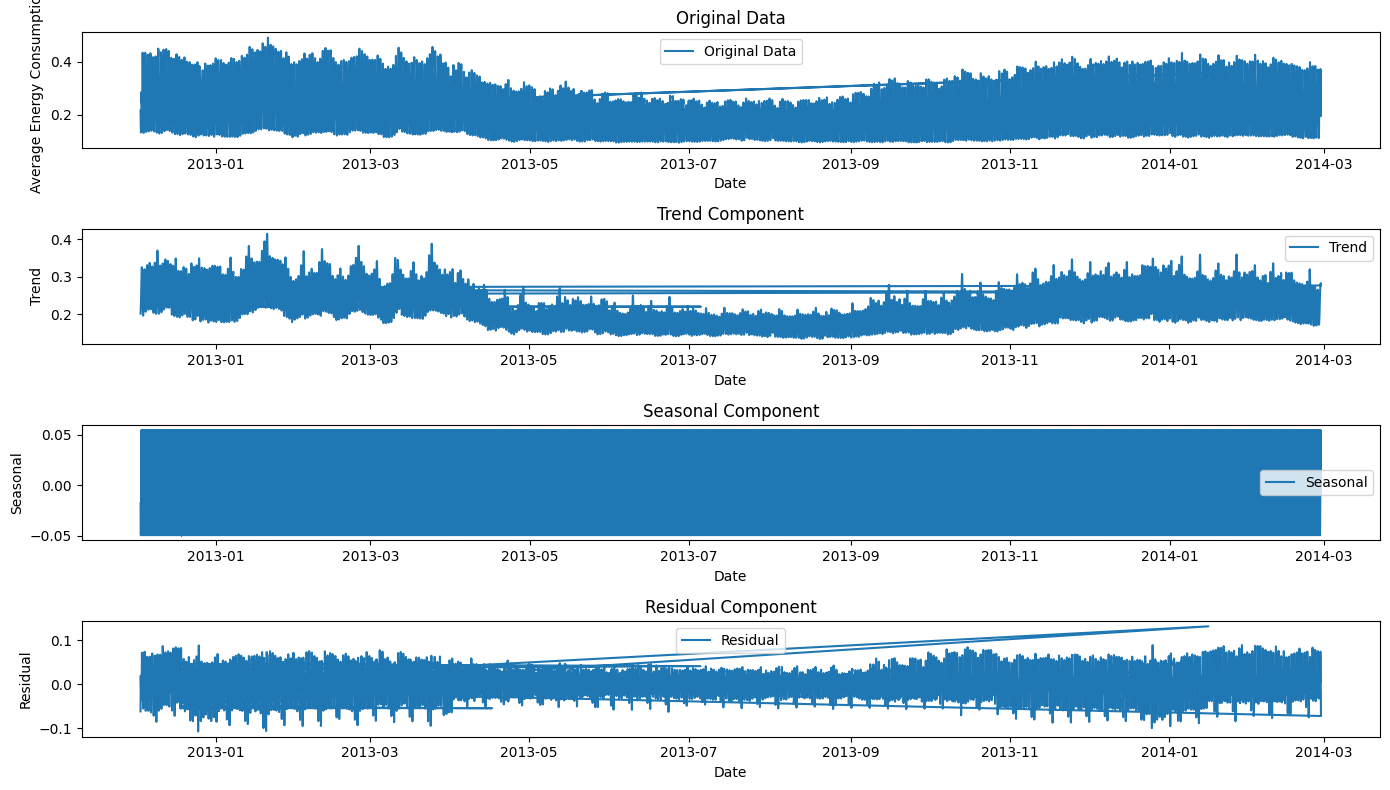

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming you have a DataFrame named 'energy_data' with columns 'DateTime' and 'average_energy_consumption'
# Convert 'DateTime' to datetime format if it's not already in that format
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Set 'DateTime' as the index
df.set_index('DateTime', inplace=True)

# Resample the data to a frequency (e.g., hourly) if needed
# energy_data = energy_data.resample('H').mean()

# Decompose the time series into trend, seasonal, and residual components
result = seasonal_decompose(df['average_energy_consumption'], model='additive', period=24)

# Plot the original data, trend, seasonal, and residual components
plt.figure(figsize=(14, 8))

plt.subplot(4, 1, 1)
plt.plot(df.index, df['average_energy_consumption'], label='Original Data')
plt.title('Original Data')
plt.xlabel('Date')
plt.ylabel('Average Energy Consumption')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(df.index, result.trend, label='Trend')
plt.title('Trend Component')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(df.index, result.seasonal, label='Seasonal')
plt.title('Seasonal Component')
plt.xlabel('Date')
plt.ylabel('Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(df.index, result.resid, label='Residual')
plt.title('Residual Component')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
from sklearn.model_selection import train_test_split

# Assuming 'Timestamp' is your timestamp and 'average_energy_consumption' is the energy consumption
X = df[['DateTime']]
y = df['average_energy_consumption']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Creating DataFrames for train and test sets
train_data = pd.DataFrame({'ds': X_train['DateTime'], 'y': y_train, 'LCLid': None})
test_data = pd.DataFrame({'ds': X_test['DateTime'], 'y': y_test, 'LCLid': None})

# Printing the shapes of the resulting sets
print("Training set shapes - X_train:", X_train.shape, "y_train:", y_train.shape)
print("Testing set shapes - X_test:", X_test.shape, "y_test:", y_test.shape)


test_data

Training set shapes - X_train: (17776, 1) y_train: (17776,)
Testing set shapes - X_test: (4444, 1) y_test: (4444,)


,ds,y,LCLid
1534,2013-01-03 23:00:00,0.276272,None
15820,2013-10-28 14:00:00,0.214044,None
9725,2013-06-23 14:30:00,0.226141,None
19673,2014-01-16 21:00:00,0.364681,None
10193,2013-07-03 08:30:00,0.184311,None
...,...,...,...
9115,2013-06-10 21:30:00,0.260438,None
1586,2013-01-05 01:00:00,0.179833,None
6,2012-12-03 03:00:00,0.137177,None
2743,2013-01-29 03:30:00,0.123812,None


In [7]:
print("Training set timestamps - Min:", train_data['ds'].min(), "Max:", train_data['ds'].max())
print("Testing set timestamps - Min:", test_data['ds'].min(), "Max:", test_data['ds'].max())


Training set timestamps - Min: 2012-12-03 00:00:00 Max: 2014-02-28 00:00:00
Testing set timestamps - Min: 2012-12-03 01:30:00 Max: 2014-02-27 16:30:00


In [38]:
from datetime import timedelta
import pandas as pd
from prophet import Prophet

# Creating and fitting the model
model = Prophet(yearly_seasonality=True, seasonality_mode='additive', interval_width=0.95)
model.fit(train_data)

# Assuming your last timestamp in the test_data is '2021-05-14'
last_timestamp = test_data['ds'].max()

# Creating a DataFrame with future dates (e.g., forecasting for the next 30 days)
future_dates = pd.DataFrame({'ds': pd.date_range(last_timestamp + timedelta(days=1), periods=730, freq='D')})

# Making predictions for the future dates
future_forecast = model.predict(future_dates)

# Post-processing to set lower uncertainty limit to zero
future_forecast['yhat_lower'] = future_forecast['yhat_lower'].clip(lower=0)

# Plotting the forecast
fig = model.plot(future_forecast)

# Plotting components
fig = model.plot_components(future_forecast)



ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

12:02:45 - cmdstanpy - INFO - Chain [1] start processing
12:02:51 - cmdstanpy - INFO - Chain [1] done processing
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-pack

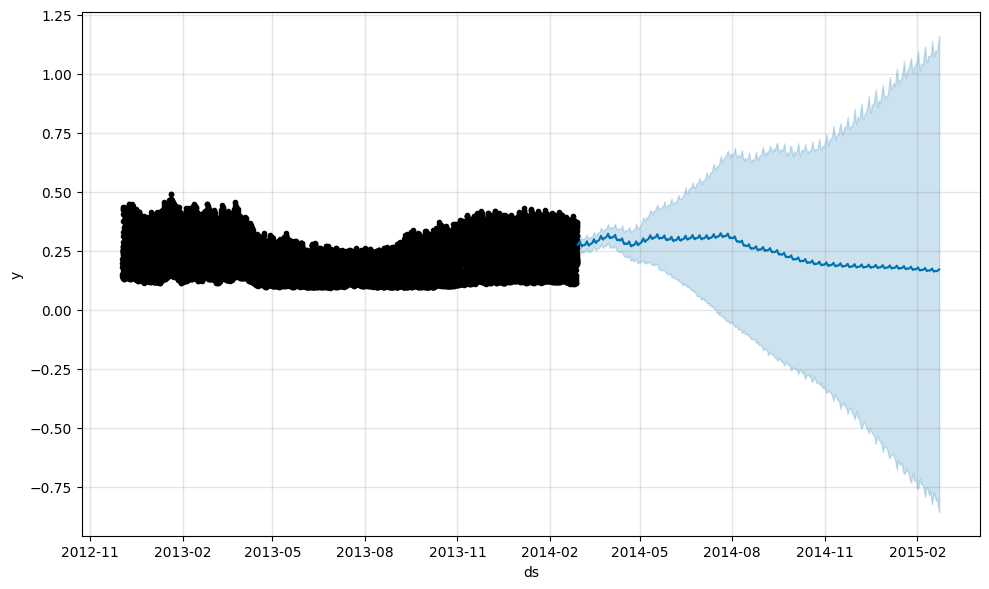

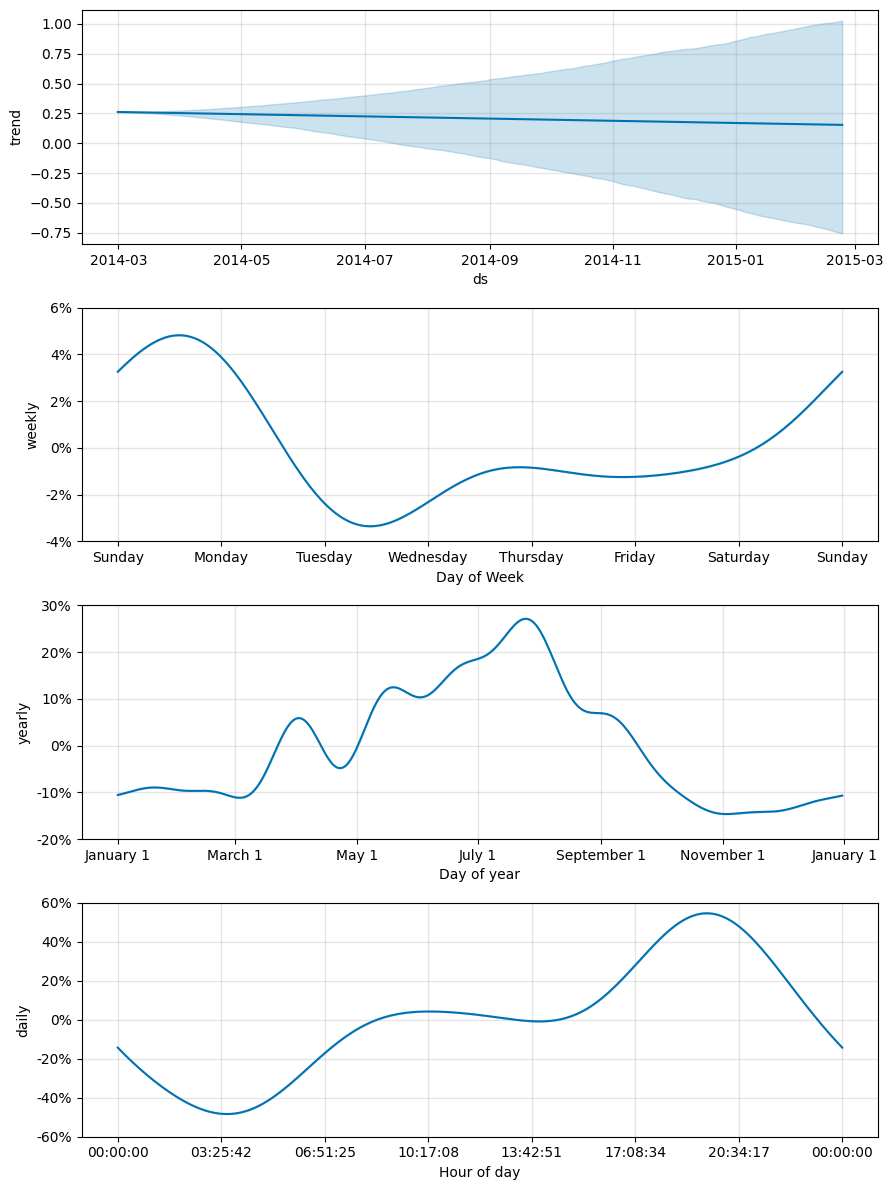

In [15]:
from datetime import timedelta
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Creating and fitting the model with daily and weekly seasonality
model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True, seasonality_mode='multiplicative',)
model.fit(train_data)

# Assuming your last timestamp in the test_data is '2021-05-14'
last_timestamp = test_data['ds'].max()

# Creating a DataFrame with future dates for prediction
future_dates = pd.DataFrame({'ds': pd.date_range(last_timestamp + timedelta(days=1), periods=360, freq='D')})

# Making predictions for the future dates
future_forecast = model.predict(future_dates)

# Plotting the forecast
fig = model.plot(future_forecast)

# Plotting the seasonality components
fig_seasonality = model.plot_components(future_forecast)
plt.show()


11:26:18 - cmdstanpy - INFO - Chain [1] start processing
11:26:23 - cmdstanpy - INFO - Chain [1] done processing
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/sit

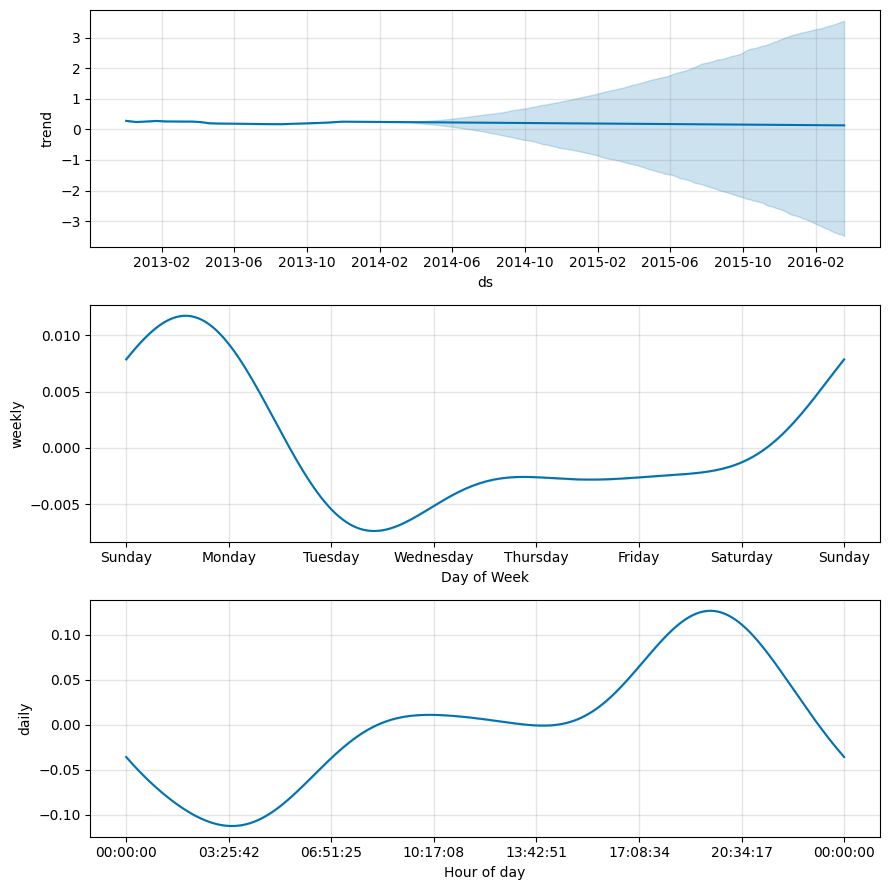

In [10]:
from datetime import timedelta
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Assuming your DataFrame has columns 'DateTime' and 'average_energy_consumption'
df['DateTime'] = pd.to_datetime(df['DateTime'])
prophet_data = df[['DateTime', 'average_energy_consumption']]
prophet_data.columns = ['ds', 'y']  # Rename columns to 'ds' and 'y'

# Create and fit the model
model = Prophet(seasonality_mode='additive')
model.fit(prophet_data)

# Create a DataFrame with future dates for prediction
future = model.make_future_dataframe(periods=750)  # Assuming you want to predict for the next 365 days

# Make predictions
forecast = model.predict(future)

# Plot the components
fig = model.plot_components(forecast)
plt.show()


In [11]:

# Assuming your last timestamp in the test_data is '2021-05-14'
last_timestamp = test_data['ds'].max()

# Creating a DataFrame with future dates (e.g., forecasting for the next 30 days)
future_dates = pd.DataFrame({'ds': pd.date_range(last_timestamp + timedelta(days=1), periods=720, freq='D')})

# Making predictions for the future dates
future_forecast = model.predict(future_dates)

# Aligning observed and predicted values based on timestamps
merged_df = pd.merge(test_data, future_forecast[['ds', 'yhat']], on='ds', how='outer')

# Extracting observed and predicted values
y_test_aligned = merged_df['y']
y_pred_aligned = merged_df['yhat']

# Dropping NaN values
merged_df = merged_df.dropna(subset=['y', 'yhat'])

# Extracting observed and predicted values again after handling NaN values
y_test_aligned = merged_df['y']
y_pred_aligned = merged_df['yhat']

# Checking if arrays are non-empty before calculating metrics
if len(y_test_aligned) > 0 and len(y_pred_aligned) > 0:
    from sklearn.metrics import mean_absolute_error, mean_squared_error

    # Assuming 'y' is the observed values and 'yhat' is the predicted values
    mae = mean_absolute_error(y_test_aligned, y_pred_aligned)
    mse = mean_squared_error(y_test_aligned, y_pred_aligned)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test_aligned - y_pred_aligned) / y_test_aligned)) * 100

    print("MAE:", mae)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAPE:", mape)
else:
    print("Error: Empty arrays. Check data alignment.")

Error: Empty arrays. Check data alignment.


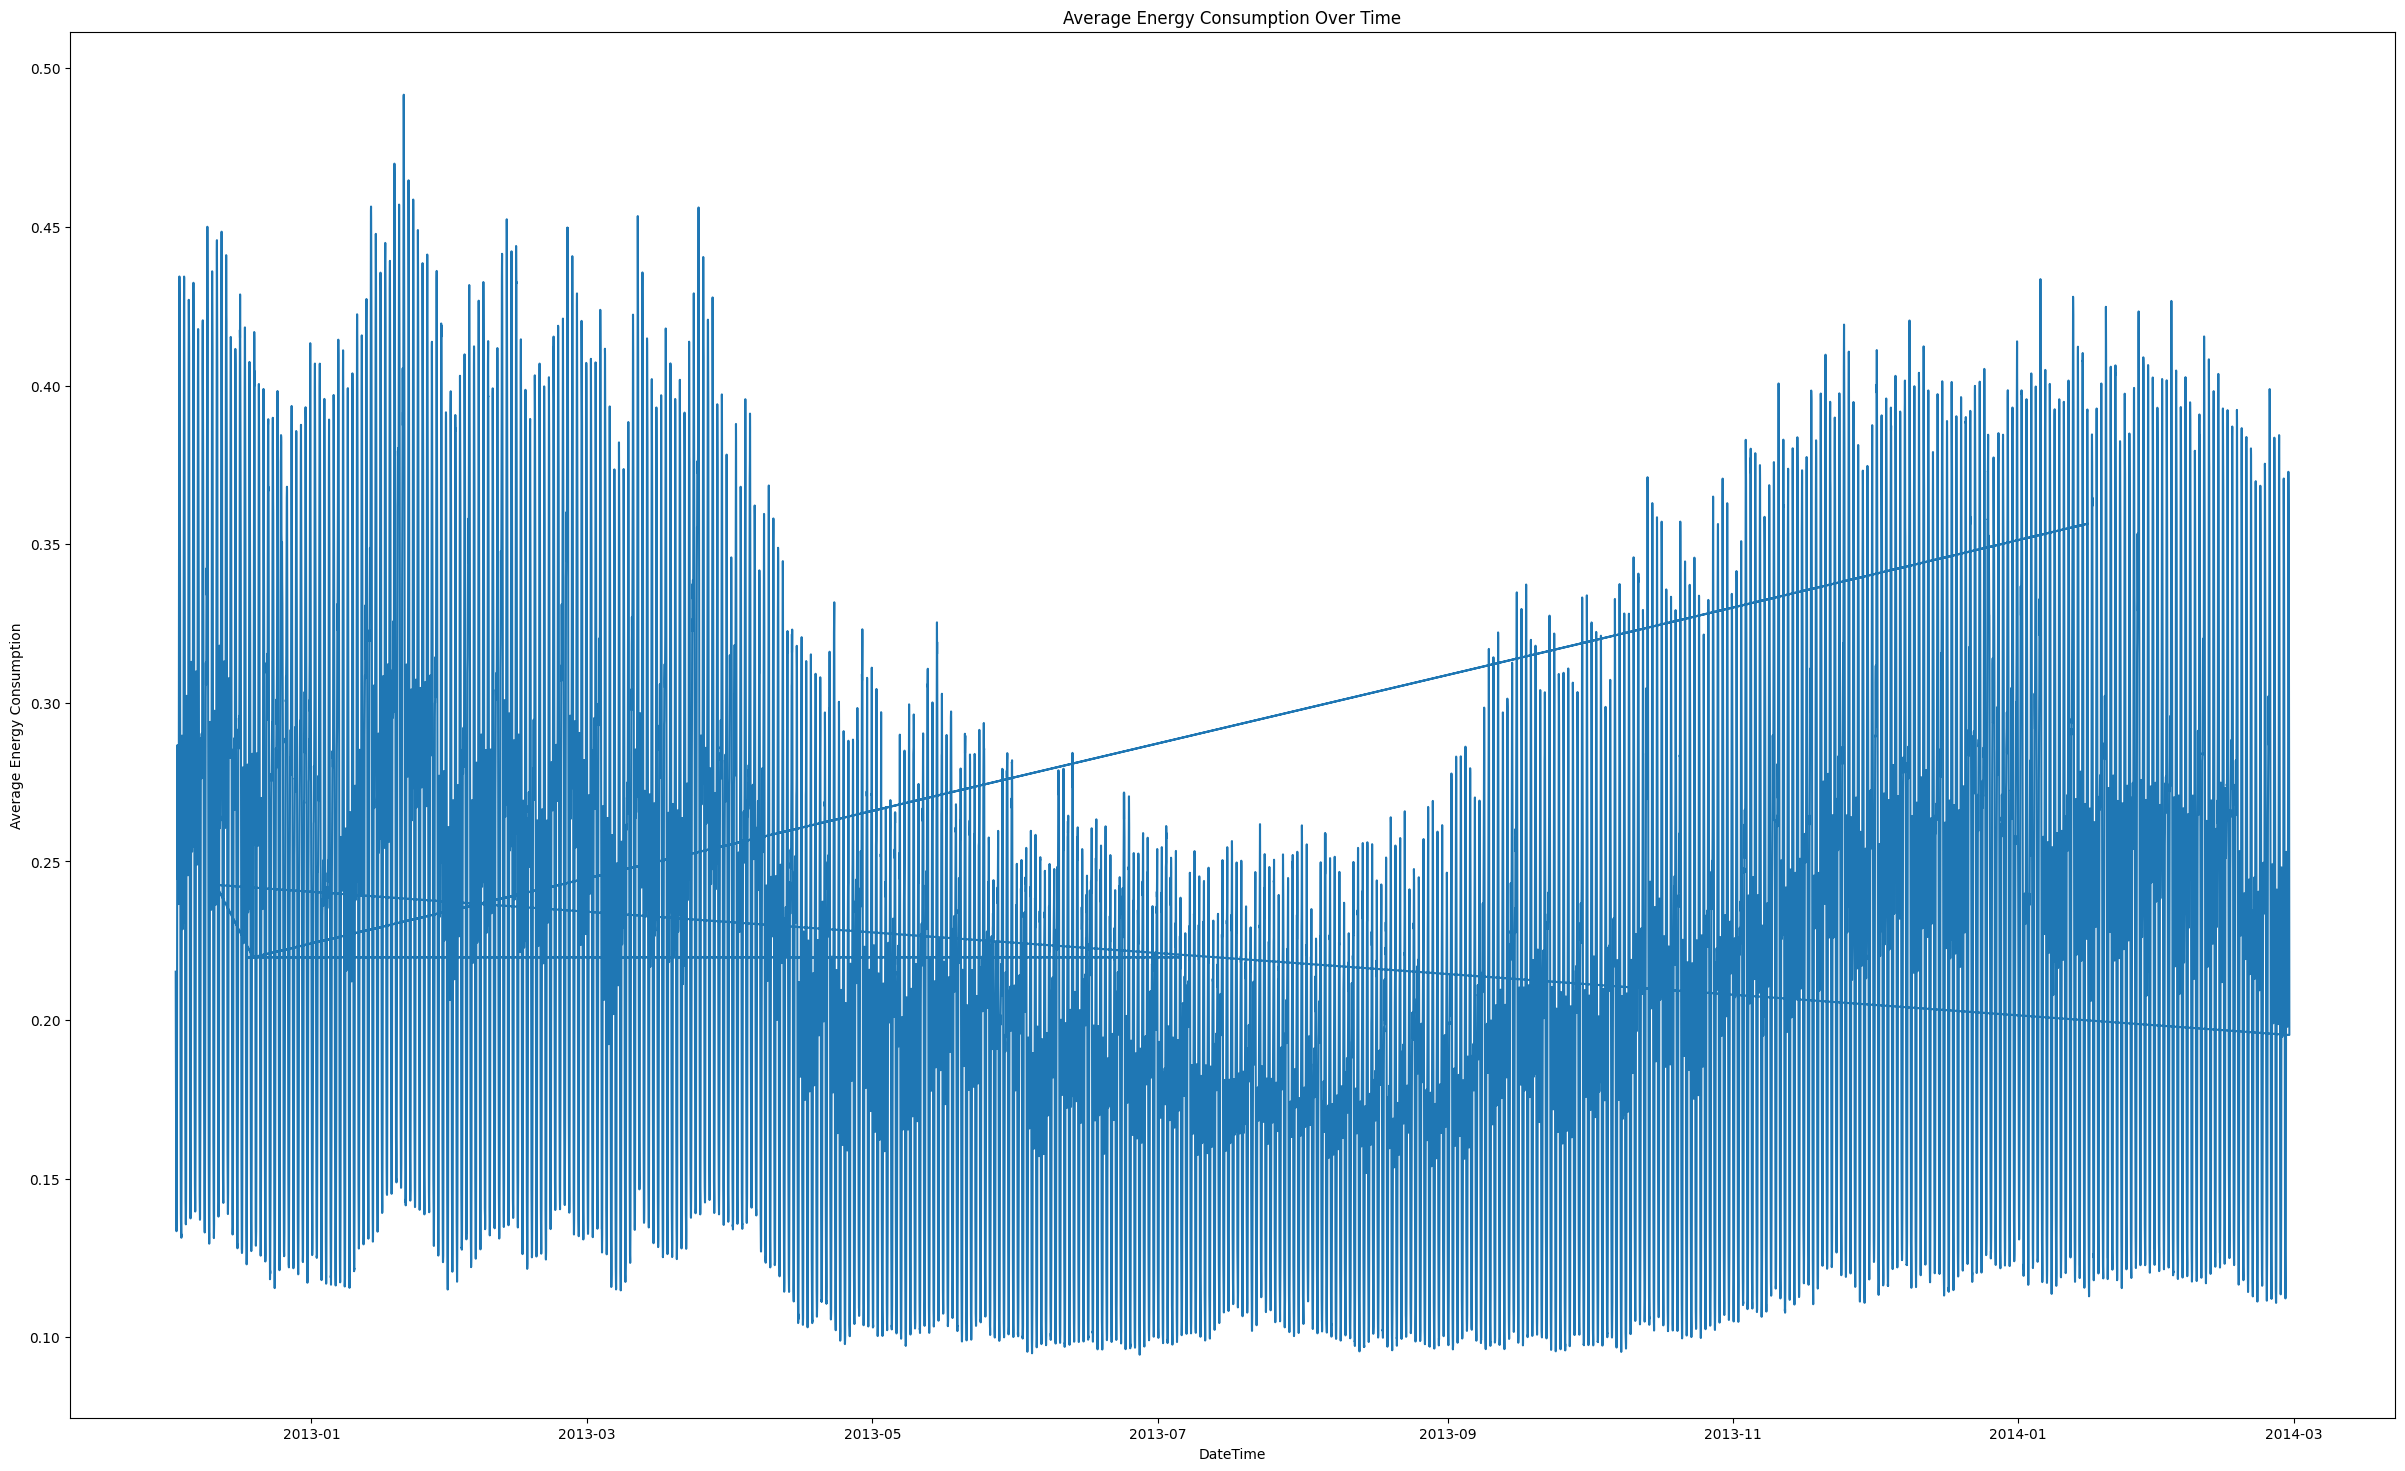

In [12]:
import matplotlib.pyplot as plt

# Plot 'average_energy_consumption' over time
plt.figure(figsize=(30, 18))
plt.plot(df_final['DateTime'], df_final['average_energy_consumption'])
plt.title('Average Energy Consumption Over Time')
plt.xlabel('DateTime')
plt.ylabel('Average Energy Consumption')
plt.show()

11:26:29 - cmdstanpy - INFO - Chain [1] start processing
11:26:33 - cmdstanpy - INFO - Chain [1] done processing
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


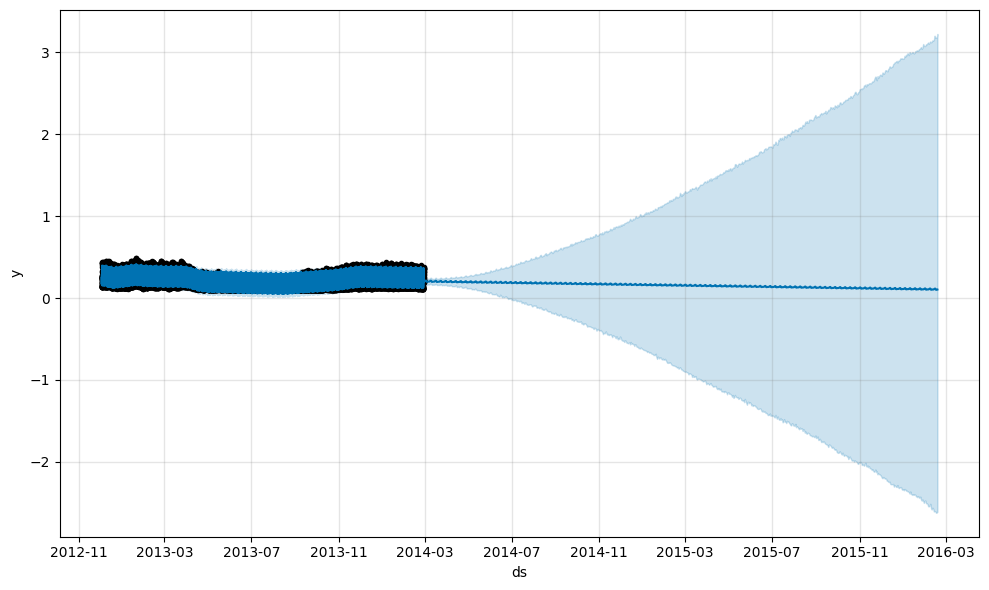

/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/Users/alexmellers/Documents/GitHub/GrowingTogether/.venv/lib/python3.12/site-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in

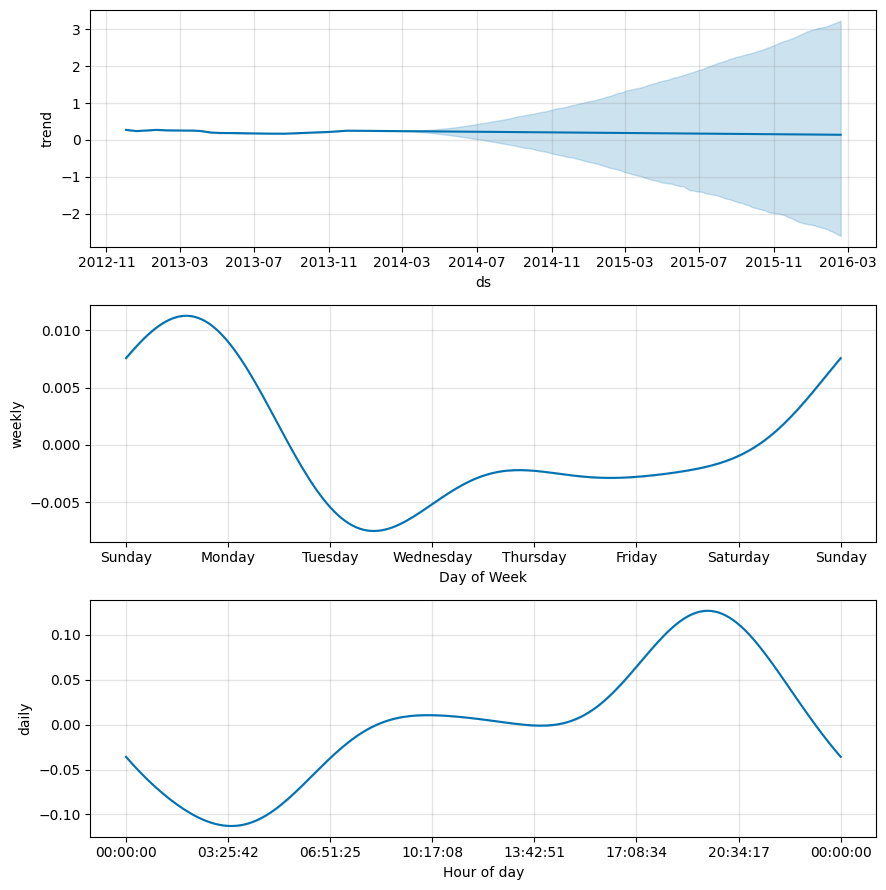

In [13]:
from sklearn.model_selection import train_test_split

# Assuming 'DateTime' is your timestamp and 'average_energy_consumption' is the energy consumption
X = df[['DateTime']]
y = df['average_energy_consumption']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Creating DataFrames for train and test sets
train_data = pd.DataFrame({'ds': X_train['DateTime'], 'y': y_train})
test_data = pd.DataFrame({'ds': X_test['DateTime'], 'y': y_test})

# Creating and fitting the model
model = Prophet(daily_seasonality=True, weekly_seasonality=True)
model.fit(train_data)

# Creating a DataFrame with future dates for 6 months
future = model.make_future_dataframe(periods=24*30, freq='D')

# Making predictions
forecast = model.predict(future)

# Plotting the forecast
fig = model.plot(forecast)
plt.show()

fig = model.plot_components(forecast)
plt.show()

In [14]:
missing_values = df.isnull().sum()

# Remove duplicates
df.drop_duplicates(inplace=True)

# Identify and handle outliers (you can customize the threshold)
outlier_threshold = 3
df = df[(df['KWH/hh (per half hour) '] < outlier_threshold)]


# Check data range
start_date = '2012-10-12'
end_date = '2014-02-28'
df = df[(df['DateTime'] >= start_date) & (df['DateTime'] <= end_date)]

# Convert timestamp to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])

KeyError: 'KWH/hh (per half hour) '

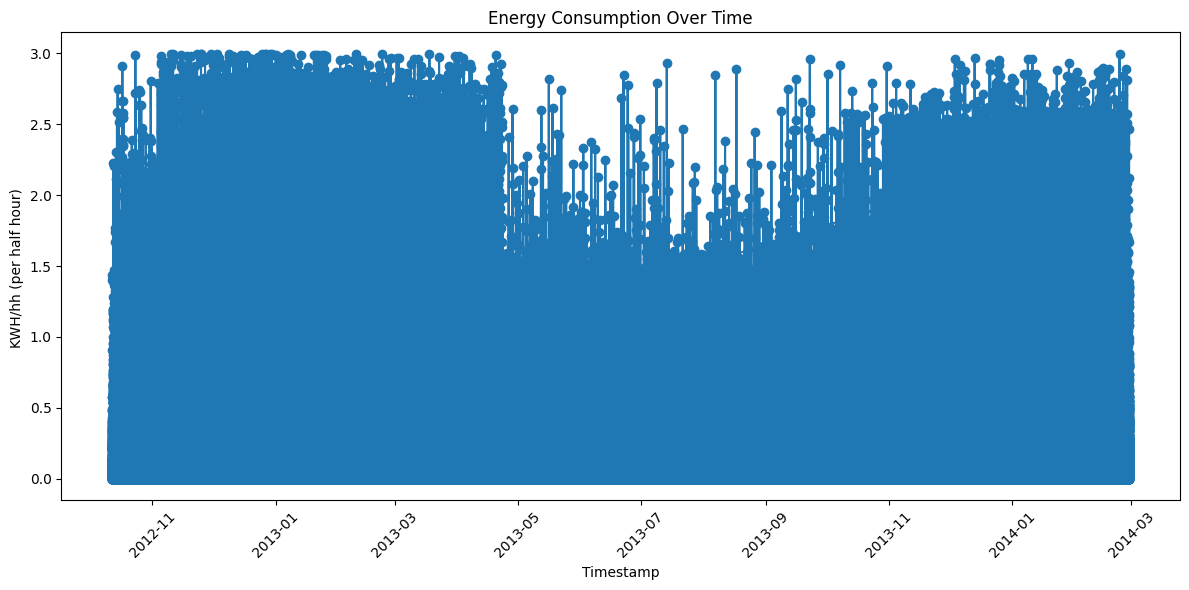

In [ ]:
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Plot the timestamp against 'KWH/hh (per half hour)'
plt.figure(figsize=(12, 6))
plt.plot(df['DateTime'], df['KWH/hh (per half hour) '], marker='o', linestyle='-')
plt.title('Energy Consumption Over Time')
plt.xlabel('Timestamp')
plt.ylabel('KWH/hh (per half hour) ')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()